# **Transfer Learning: Vision Transformers**
## **Image Classification**

---

Transfer learning is a technique where a pre-trained model, which has already learned features from one task, is used as the starting point for a similar task. This saves time and resources by leveraging the existing knowledge of the model instead of training a new model from scratch.

In this tutorial, we will be looking at how we can apply transfer learning for image classification with a Vision Transformer on any dataset of our choice.

In transfer learning, we do not need to update the parameters of the entire model. Since our ViT has learned feature representations from millions of images, we can just choose to train the very last layers of our model to make it perform well on our new dataset.

For this tutorial, we will be using [google/vit-base-patch16-224](https://huggingface.co/google/vit-base-patch16-224) model from the Hugging Face hub.

### Let's begin by importing some necessary modules and functions
---

In [1]:
!pip install --quiet evaluate
!pip install -U -q datasets transformers[torch] evaluate timm albumentations accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [3]:
# Login onto Hugging Face hub to load any private dataset/model.
# We need to login as we'll also upload our model to the hub
notebook_login()

### Loading image classification dataset
---

#### The dataset contains the following features:

- path: a path to the file
- label: have or not brain tumor
- image: a PIL format image

In [4]:
dataset = load_dataset('Mahadih534/brain-tumor-dataset')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/253 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/253 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 253
    })
})

In [84]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=630x630>,
 'label': 0}

In [5]:
labels = dataset['train'].unique('label')
print(len(labels),labels)

2 [0, 1]


#### Let's see some sample images from our dataset
---

For any dataset we use with the `datasets` library, we can shuffle the dataset using `shuffle()` and, select any samples using the `select()` method.

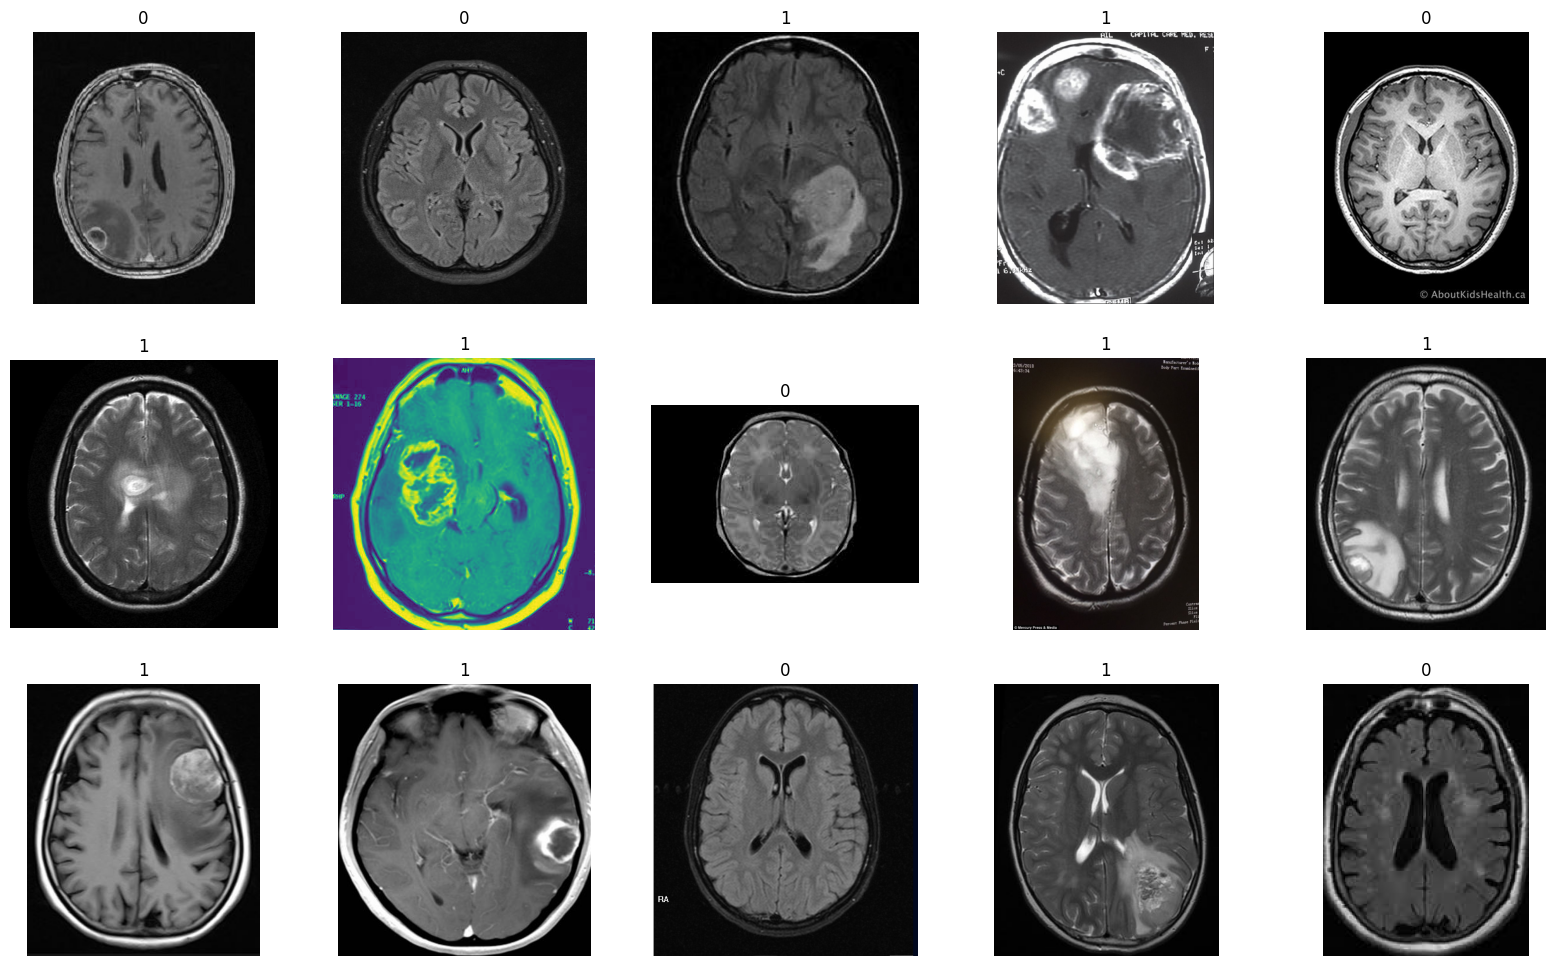

In [86]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(dataset['train'],rows=3,cols=5)

## Preprocessing our dataset
---

When it comes to image datasets, preprocessing involves multiple steps. This includes transforms such as resizing all images to have the same dimensions, normalizing, and scaling the pixel values to a uniform range. We can also add augmentations to our images like random flips, rotations, perspectives, etc.

Before we apply our transforms, let's split our dataset into 3 parts for training, validation  and a hidden test set to evaluate how our model performs. We can use the in-built `train_test_split` method to do so.

Since we only have a `train` split in our original dataset, we'll use 80% of it for training and 10% for `validation` and remaining 10% as our `test` split.

In [6]:
split_dataset = dataset['train'].train_test_split(test_size=0.2) # 80% train, 20% evaluation
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5) # 50% validation, 50% test

# recombining the splits using a DatasetDict

our_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

our_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 202
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 26
    })
})

It is important to note that any model cannot understand the labels in their `string` format. Hence, we map them to their integer counterparts. Since there are 37 labels, the labels will be mapped to a number from 0 to 36.

We'll create two mappings, `label2id` and `id2label` to convert the labels to their IDs and vice versa. This is also be useful when we initialize our model to update its configuration.

In [144]:
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

### Image Processor

To apply the right transforms on our images, we will be using [AutoImageProcessor](https://huggingface.co/docs/transformers/main_classes/image_processor) which will apply the transforms according to the model we will use. We can check its configuration to see what transforms will be applied.

In [7]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To apply the transforms to a batch at the time of training, we can create a function which will preprocess the batch. The trainer will call this function when we add it to the dataset using `with_transform`.

At the time of training, we need to apply the transforms on a batch of samples. To handle the batches, we'll create a `transforms` function which will take care of the following:

- Converting all images into RGB: It might be possible that some images in your dataset will be grayscale or transparent (RGBA).
- Converting the string labels to integers: using the `label2id` map.
- Applying image transforms: we pass the images through the `processor` to process, and convert them into PyTorch format.

The resultant dataset features will be:
```py
{
    'pixel_values': torch.Tensor,
    'labels': List
}
```

We'll pair the function with our dataset using the `with_transform()` method.

In [8]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

In [147]:
processed_dataset = our_dataset.with_transform(transforms)

In [148]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 202
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 26
    })
})

#### Data Collation

Batching our data in the correct format is collation. For `pixel_values`, the input shape for the model should be `(batch, channels, height, width)` and for `labels`, the shape should be `(batch,)`

In [149]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Let's see how to calculate the metrics
---

We can use Hugging Face `evaluate` library to calculate the metrics. For image classification, we can use the accuracy metric.

In [150]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

## Loading our Model
---

We will use [ViTForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTForImageClassification) to load our pre-trained model.

We do need to update the final classification layer, to output predictions equal to the number of labels in our dataset.
We will do that by passing in `num_labels` argument along with our label mappings `id2label` and `label2id`.

We also need to pass `ignore_mismatched_sizes = True` to compensate for the change in number of parameters in the classification layer.

In [165]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Here's the architecture of our model

In [152]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

Since we are not going to update the entire model, we can "freeze" all the parameters except for the new `classifier` layer by setting `requires_grad` to False for each layer's parameters.

In [166]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

We can check how many parameters are there in the model along with how many are actually going to be trained now.

In [167]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,800,194 | trainable_params = 1,538


# Let's commence our training 🚀️🚀️🚀️
---

We'll be using [Hugging Face Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer) to train our model. Feel free to choose your training arguments such as the batch size, learning rate, number of epochs, logging options, etc.

With respect to image classification, we do need to set `remove_unused_columns=False` to prevent the `image` column in our dataset to be removed, since it is the one being used to create our `pixel_values` inputs.

In [168]:
training_args = TrainingArguments(
    output_dir="./vit-base-oxford-brain-tumor",
    per_device_train_batch_size=20,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=7,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [169]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

In [170]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.590356,0.640000
2,No log,0.527639,0.680000
3,No log,0.486355,0.800000
4,No log,0.456650,0.800000
5,No log,0.439039,0.880000
6,No log,0.429446,0.960000
7,No log,0.425905,0.960000


TrainOutput(global_step=77, training_loss=0.5900365656072443, metrics={'train_runtime': 1220.4662, 'train_samples_per_second': 1.159, 'train_steps_per_second': 0.063, 'total_flos': 1.0957367331503309e+17, 'train_loss': 0.5900365656072443, 'epoch': 7.0})

### evaluating on our test dataset

In [171]:
processed_dataset['test']

Dataset({
    features: ['image', 'label'],
    num_rows: 26
})

In [172]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.5719394087791443,
 'eval_accuracy': 0.6923076923076923,
 'eval_runtime': 17.1226,
 'eval_samples_per_second': 1.518,
 'eval_steps_per_second': 0.234,
 'epoch': 7.0}

### let's look at some of the predictions made by our new model!

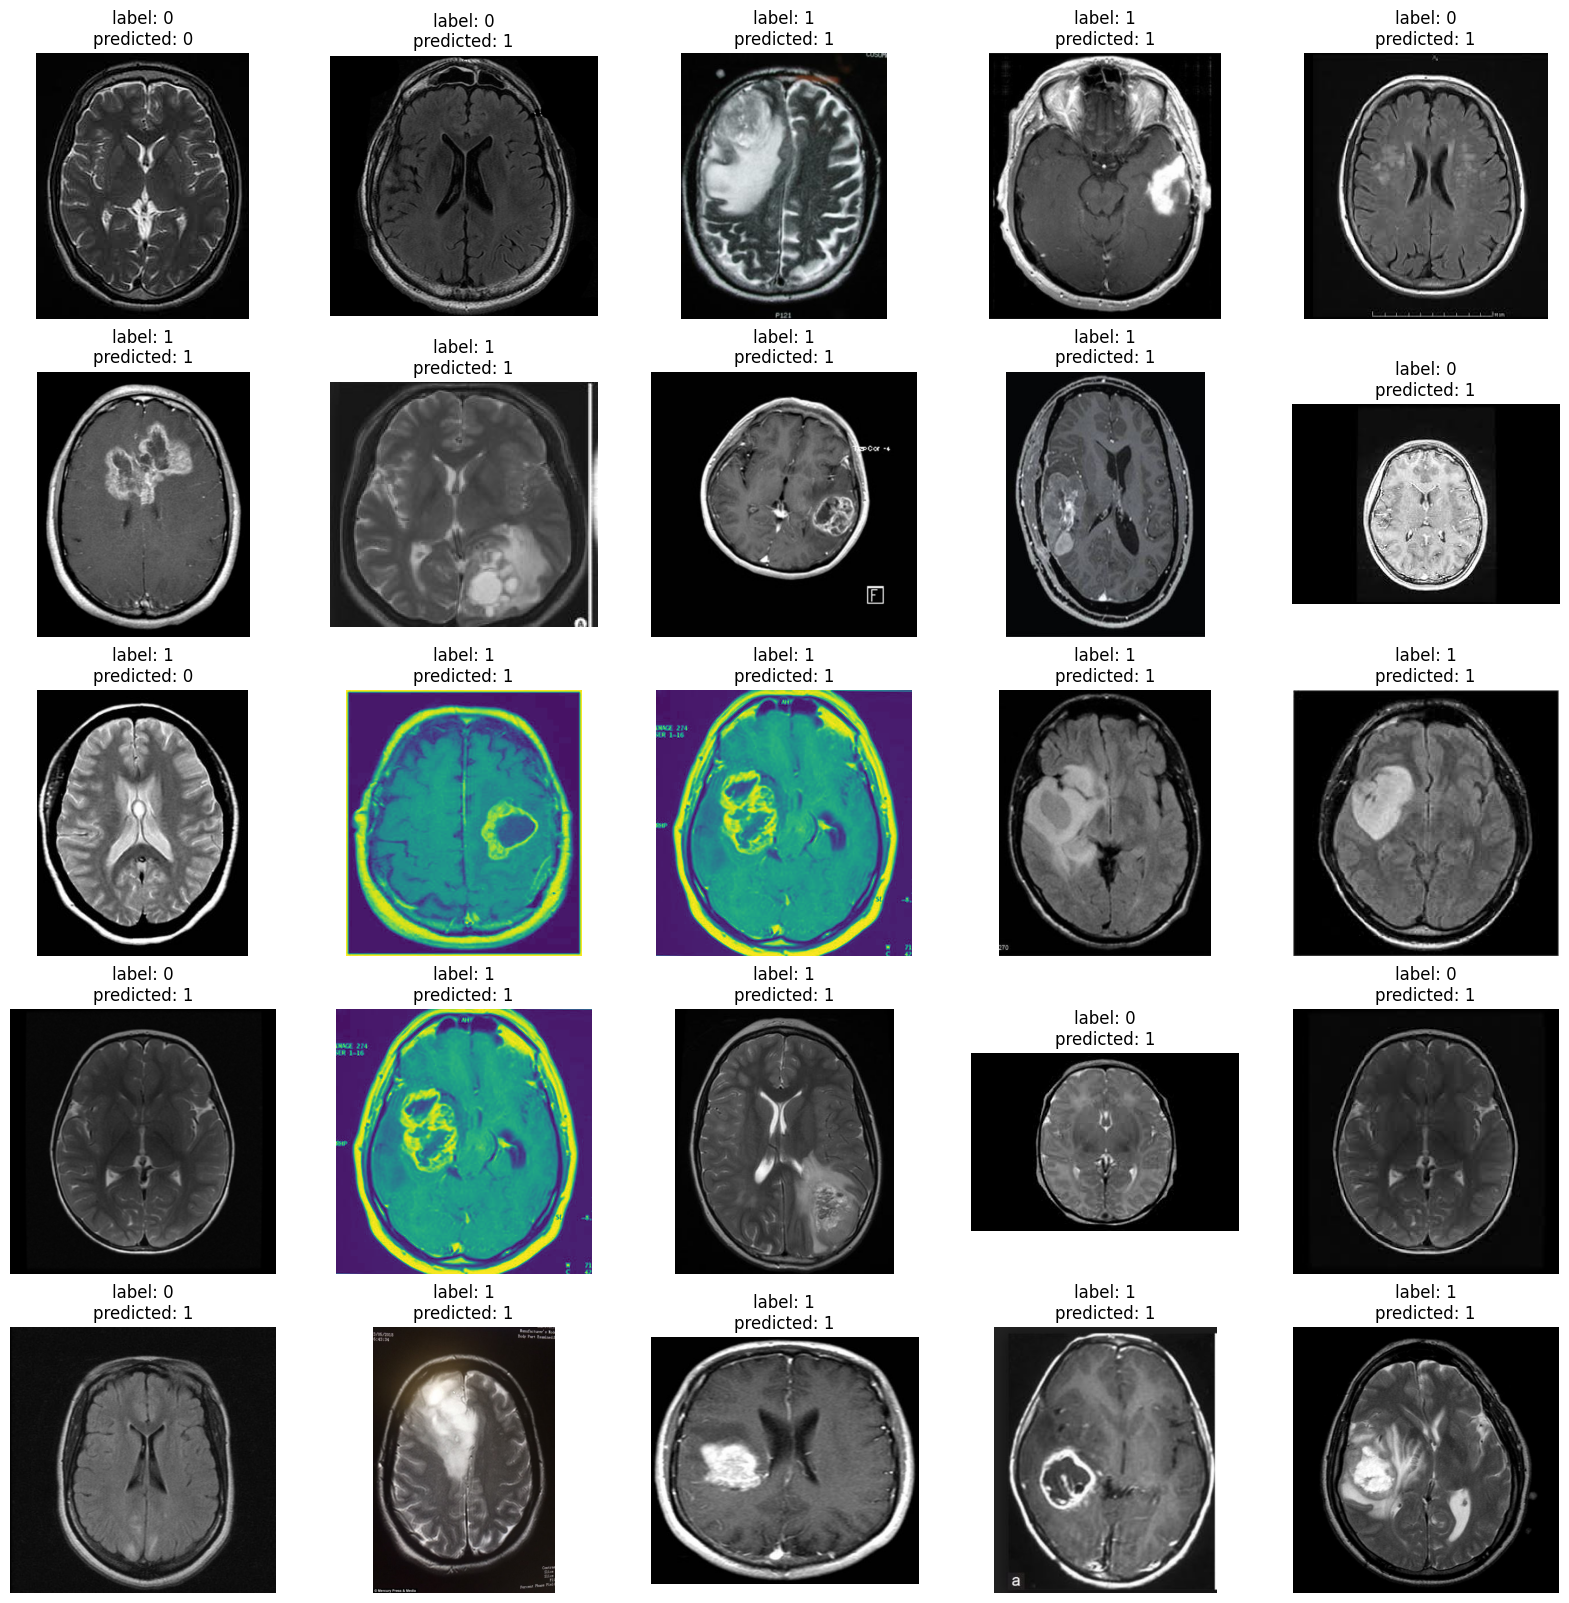

In [173]:
def show_predictions(rows,cols):
    samples = our_dataset['test'].shuffle().select(np.arange(rows*cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # predicted labels from logits
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img = samples[i]['image']
        prediction = predictions[i]
        #label = f"label: {samples[i]['label']}\npredicted: {prediction}"
        label = f"label: {samples[i]['label']}\npredicted: {id2label[prediction]}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_predictions(rows=5,cols=5)

### Our model works really well! Let's save it and also push it to Hugging Face model hub!

In [174]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "dataset": 'Mahadih534/brain-tumor-dataset',
    "tasks": "image-classification",
    "tags": ['image-classification'],
}

In [175]:
trainer.save_model()
trainer.push_to_hub('brain_tumor', **kwargs)

events.out.tfevents.1717959484.3461f2516c4a.3087.13:   0%|          | 0.00/405 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AMfeta99/vit-base-oxford-brain-tumor/commit/fd6fc520972a772a6e88a29e57195df725eda04f', commit_message='brain_tumor', commit_description='', oid='fd6fc520972a772a6e88a29e57195df725eda04f', pr_url=None, pr_revision=None, pr_num=None)

##  Gradio Demo

In [ ]:
pip install gradio

In [37]:
import gradio as gr
from transformers import pipeline
from PIL import Image

# Define the image classification function
def classify_image(image):
    try:
        # Convert the Gradio image input (which is a NumPy array) to a PIL image
        image = Image.fromarray(image)

        # Create the image classification pipeline
        img_class = pipeline(
            "image-classification", model="AMfeta99/vit-base-oxford-brain-tumor"
        )

        # Perform image classification
        results = img_class(image)

        # Find the result with the highest score
        max_score_result = max(results, key=lambda x: x['score'])

        # Extract the predicted label
        predictions = max_score_result['label']

        return predictions

    except Exception as e:
        # Handle any errors that occur during classification
        return f"Error: {str(e)}"

# Define the Gradio interface
image = gr.Image()
label = gr.Label(num_top_classes=1)
title = "Brain Tumor X-ray Classification"
description = "Worried about whether your brain scan is normal or not? Upload your x-ray and the algorithm will give you an expert opinion. Check out [the original algorithm](https://huggingface.co/AMfeta99/vit-base-oxford-brain-tumor) that this demo is based off of."
article = "<p style='text-align: center'>Image Classification | Demo Model</p>"
demo = gr.Interface(fn=classify_image, inputs=image, outputs=label, description=description, article=article, title=title)

# Launch the Gradio interface
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3a4d778ae282361ff6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
